<a href="https://colab.research.google.com/github/yingzibu/JAK_ML/blob/main/examples/experiments/finetune/ADMET_10_31_uncertainty_weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu118
cuda:  True


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

#### Code

In [ ]:
from os import walk
import os
file_types = ['bin', 'pth']

# clean certain type of file in path
def clean_files(path='/content/drive/MyDrive/ADMET/', file_types = ['pth', 'bin', 'pt', 'yml']):
    files = next(walk(path), (None, None, []))[2]
    for file in files:
        if isinstance(file, str):
            file_type = file.split('.')[-1]
            if file_type in file_types:
                os.remove(file); print(f'removed from {path}: {file} ')
# clean_files()

In [2]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [3]:
# test scripts.func_utils.py

from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *

from tdc.utils import retrieve_label_name_list
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
label_list = retrieve_label_name_list('herg_central')

def collect_data(names:list, clean_mol_=False, verbose=False):
    if isinstance(names, str): names = [names]
    name_adme = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
                 'HydrationFreeEnergy_FreeSolv',
                 'Solubility_AqSolDB'] # regression task
    name_adme+= ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                'CYP1A2_Veith', 'CYP2C9_Veith'] + \
                ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli',
                 'HIA_Hou','PAMPA_NCATS'] # classify
    print('collect data for: ', names)
    label_list = retrieve_label_name_list('herg_central')
    for i, name in enumerate(names):
        if verbose: print('*'*15, name, '*'*15)
        if name in label_list: data = Tox(name='herg_central', label_name=name)
        elif name in name_adme: data = ADME(name=name)
        else:
            try: data = Tox(name=name)
            except: print('cannot read data!'); return
            if verbose: data.label_distribution()
            # data.label_distribution()
        split = data.get_split()
        train, valid, test = split['train'], split['valid'], split['test']
        if clean_mol_:
            train, valid, test = clean_mol(train), clean_mol(valid), clean_mol(test)

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if i == 0: trains, valids, tests = train.copy(), valid.copy(), test.copy()
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')

    return trains, valids, tests
# trains, valids, tests = collect_data_10_27(names_reg[0])




VOCAB_TYPE: smiles, could change from ['char', 'smiles', 'selfies'] at get_vocab.py


In [4]:

import yaml
def yml_report(yml_path, recalculate=False, ver=False):
    """
    given yml path or yml data, return the test set performance
    param
        yml_path        : str,  the path of yml file
        recalculate     : bool, if true, will calculate from scratch
        ver             : bool, if true, will print detailed configs
    return perfm_dict   : dict, contain performance and test loss
    """
    if isinstance(yml_path, str): # the path string was input
        with open(yml_path, 'r') as f: data = yaml.safe_load(f)
    elif isinstance(yml_path, dict):   data = yml_path # data was input

    config = data['config']
    model_type = config['model_type']
    task_names = config['prop_names']
    perfm_dict =  data['performance']

    if len(perfm_dict) != 0 and recalculate == False:
        # during training, has evaluted test set, no need to calculate again
        # However for regression, the pred vs true value for test is not saved
        # if need the regression pred vs true value graph, need recalculate
        if ver: # print model config, and the training saved info
            print('#'*68); print('#'*30, 'CONFIG', '#'*30); print('#'*68)
            for i, j in config.items(): print(i, ':', j)
            print('#'*68)
            print('Model parameters: ', data['params_num'])
            times_list = data['times_list']
            print(f'Train time: {np.mean(times_list):.3f}'
                  f'+/-{np.std(times_list):.3f} ms')
            print(f"best epoch: {data['best_epoch']}, ",
                  f"min loss: {data['min_loss']:.4f}")
            plot_loss(data['train_dict'], data['valid_dict'], name='valid',
                      title_name= f'loss during training {model_type}')

    else: # recalculate from scratch using test data
        vocab = None if 'vocab' not in config else config['vocab']
        trains, valids, tests = collect_data_10_27(task_names)
        if config['scale_dict'] != None: # scale is done
            trains, valids, tests, dict_scale = scale(trains, valids, tests)
            assert config['scale_dict'] == dict_scale
        batch_size = config['batch_size']
        param_t = {'batch_size': batch_size, 'shuffle': False,
                'drop_last': False, 'num_workers': 0}
        test_loader = get_loader(tests, task_names, param_t, model_type, vocab)
        models = PRED(**config); models.load_status(data)
        outputs = models.eval(test_loader, ver=ver)
        perfm_dict = outputs[0]
    return perfm_dict


import numpy as np

#                0      1        2       3        4     5      6      7      8
cls_metrics = ['acc', 'w_acc', 'prec', 'recall', 'sp', 'f1', 'auc', 'mcc', 'ap']
reg_metrics = ['mae', 'mse', 'rmse', 'r2']
d = {'reg': [0,   2,    3], 'cls': [0,   5,  6]}
#            mae, rmse, r2          acc, f1, auc


# evaluate performance list, if directly from yml_file saved performance (dict)
# need to [yml_file_data['performance']] to convert dict into list
def eval_perf_list(perfs:list, name:list,
                   metrics_dict=d, # could be {} # eval all
                   reg_metrics_all=reg_metrics,
                   cls_metrics_all=cls_metrics):
    """
    The same model type for multiple times, performance saved in list perfs
    Aim: evaluate performance of name, calculate mean and std for multiple run
    : param metrics_dict: dict, if None, print all metrics
                          example: {'reg': [0, 2, 3], 'cls': [0, 5, 6]}
    """
    if len(metrics_dict) == 0:  # will print all metrics
        metrics_dict['reg'] = [i for i in range(len(reg_metrics_all))]
        metrics_dict['cls'] = [i for i in range(len(cls_metrics_all))]
    if isinstance(name, str): name = [name]
    if isinstance(perfs, dict): perfs = [perfs]
    repeat_time = len(perfs) # the same model was run for # repeat_time times

    if repeat_time > 1: # multiple run, find the lowest loss
        loss_list = [p['loss'] for p in perfs]
        best_model_idx = np.argmin(loss_list) # has the lowest loss
        best_perf = perfs[best_model_idx]
        print('repeated num #', repeat_time, end=" ")
        print(f'idx {best_model_idx} has the lowest loss from {loss_list}')
    else: best_perf = None
    for n in name:
        IS_R = names_dict[n]
        # print(n, '\tRegression?', IS_R);
        if IS_R:
              idxs = metrics_dict['reg']; ms=[reg_metrics_all[i] for i in idxs]
        else: idxs = metrics_dict['cls']; ms=[cls_metrics_all[i] for i in idxs]

        results = {}
        for idx, i in enumerate(perfs): # access idx_th evaluation in perfs
            r = i[n]; results[idx] = r  # collect the evaluation for name n

        means, stds = [], []

        for idx_v in range(len(r)):
            cur_values = []
            for idx in range(repeat_time):
                cur_v = results[idx][idx_v]; cur_values.append(cur_v)
            mean_here, std_here = np.mean(cur_values), np.std(cur_values)
            means.append(mean_here); stds.append(std_here)
            # print(f'{ms[idx_v]}\t: {mean_here:.3f} +/- {std_here:.3f}')

        print('*'*20, n, '*'*20,  end=' \n\t')
        for k in ms: print('\t', k, end = ' \t ')
        print()

        for idx_final, (i, j) in enumerate(zip(means, stds)):
            if idx_final == 0:    print(end='\t| ')
            if idx_final in idxs: print(f'{i:.3f} +/- {j:.3f}', end=' | ')
        if best_perf != None:
            print(f'\n idx {best_model_idx}: ', end='| ')
            for i in idxs:
                print(f'{best_perf[n][i]:.3f} +/- {0:.3f}', end=' | ')
        print('\n')

        # break


In [5]:
def eval_multi_run(model_type, name, folder_list, repeat_time=3, run_type=None):
    if isinstance(name, str): name = [name]
    if isinstance(folder_list, str): folder_list = [folder_list]
    if run_type == None: run_type = 'ST' if len(name) == 1 else 'MT'

    for folder_ in folder_list:
        print('checking', folder_)
        try:
            perform_list = []
            for i in range(repeat_time):
                yml_name = f'{folder_}/{model_type}_{run_type}_{i}.yml'
                try:
                    p = yml_report(yml_name, ver=False); perform_list.append(p)
                except:
                    print('cannot read', yml_name); break
            if len(perform_list) != 0: eval_perf_list(perform_list, name)
        except: pass
    print()

#### Constant and configs

In [6]:
### CONSTANTS ###
names_reg = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB', 'LD50_Zhu'] # regression task
names_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
             'CYP1A2_Veith', 'CYP2C9_Veith'] + \
            ['BBB_Martins', 'Bioavailability_Ma',
             'Pgp_Broccatelli', 'HIA_Hou','PAMPA_NCATS'] + \
            ['hERG_Karim', 'AMES']

names_dict = {}
for name in names_reg + names_cls:
    if name in names_reg:   names_dict[name] = True  # regression task
    elif name in names_cls: names_dict[name] = False # classification task
names_all = list(names_dict.keys())

model_types = ['MLP', 'AttentiveFP', 'GIN', 'RNN']

#                0      1        2       3        4     5      6      7      8
cls_metrics = ['acc', 'w_acc', 'prec', 'recall', 'sp', 'f1', 'auc', 'mcc', 'ap']
reg_metrics = ['mae', 'mse', 'rmse', 'r2']


In [7]:
in_dim = 256
hid_dims = [128, 64, 16]
dropout = 0.5
lr = 3e-4
wd = 1e-5
MAX_EPOCH = 1000
patience = 30           # stop if loss no decrease after epochs # patience
verbose_frequency = 100 # print evaluation every # verbose_frequency epoch
batch_size = 128

# special for AttentiveFP
graph_feat_size = 300
n_layers = 5
num_timesteps = 1   # times of updating the graph representations with GRU

# special for GIN: pretrain model types for selection:
pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                     'gin_supervised_edgepred', 'gin_supervised_masking']
pre_model_num = 0    # choose from pre_models for GIN


# if VOCAB_TYPE == 'smiles':
import yaml
def load_vocab(VOCAB_TYPE):
    try:
        with open(f'vocab/{VOCAB_TYPE}.yml', 'r') as f: data = yaml.safe_load(f)
        vocab = data['vocab']; assert VOCAB_TYPE == data['vocab_type']
    except: vocab = None
    return vocab

# special for RNN:
VOCAB = load_vocab(VOCAB_TYPE)
Bid = True
GRU_num_layers = 3
GRU_dim = 256

scale_dict = None
uw = False # uncertainty weight

def get_config(model_type, names,
               pre_model_num=pre_model_num, scale_dict=scale_dict):
    """
    Get config to initialize model
        param model_type: str, ['MLP', 'AttentiveFP', 'GIN', 'RNN']
        param names: list, task names
        param scale_dict: dict,
            if the task is regression, could scale label values
                            {name: [value_min, value_max], ...}
        param pre_model_num: int, [0, 1, 2, 3]
            if model_type is 'GIN', 4 types of pretrained models to choose from
    Returns config that could be used as PRED(**config)
    """
    pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                         'gin_supervised_edgepred', 'gin_supervised_masking']

    # print(scale_dict)
    if isinstance(names, str): names = [names]
    IS_R = [names_dict[name] for name in names]
    config_MLP = {'model_type': 'MLP',
            'in_dim': 167,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_MLP.pt',
            'scale_dict': scale_dict}

    config_ATF = {'model_type': 'AttentiveFP',
            'graph_feat_size': graph_feat_size,
            'num_timesteps': num_timesteps,
            'n_layers': n_layers,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': 'ckpt_AT.pt',
            'scale_dict': scale_dict}

    config_GIN = {'model_type': 'GIN',
            'pretrain_model': pre_models_GIN[pre_model_num],
            'in_dim': in_dim,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'batch_size': batch_size,
            'IS_R': IS_R,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_GIN_{pre_models_GIN[pre_model_num]}.pt',
            'scale_dict': scale_dict}

    config_RNN = {'model_type': 'RNN',
              'vocab': VOCAB,
              'vocab_type': VOCAB_TYPE,
              'Bidirect': Bid,
              'num_layers': GRU_num_layers,
              'GRU_dim': GRU_dim,
              'out_dim': len(names),
              'prop_names': names,
              'dropout': dropout,
              'IS_R': IS_R,
              'device': 'cuda',
              'batch_size': batch_size,
              'lr': lr,
              'wd': wd,
              'patience': patience,
              'verbose_freq': verbose_frequency,
              'model_path': f'ckpt_RNN_{VOCAB_TYPE}.pt',
              'scale_dict': scale_dict}

    if model_type == 'MLP':           con_MO = config_MLP
    elif model_type == 'AttentiveFP': con_MO = config_ATF
    elif model_type == 'GIN':         con_MO = config_GIN
    elif model_type == 'RNN':         con_MO = config_RNN
    else: print('Error !{MLP, AttentiveFP, GIN, RNN}'); return None

    con_MO['config_path'] = con_MO['model_path'].split('.')[0] + '.yml'
    # different weight of task, initial weight the same
    con_MO['weight_loss'] = [float(1.0)] * len(names)
    con_MO['MAX_EPOCH'] = MAX_EPOCH
    con_MO['uncertainty_weight'] = uw
    return con_MO



#### read yml files examples

In [8]:
yml_name = 'Lipophilicity_AstraZeneca_scale/AttentiveFP_ST_1.yml'
p = yml_report(yml_name, ver=False)
print('Evaluate all metrics, just set metrics_dict as {}')
eval_perf_list(p, 'Lipophilicity_AstraZeneca', metrics_dict={})

print(f'Evaluate selected metrics {d}')
eval_perf_list(p, 'Lipophilicity_AstraZeneca', metrics_dict=d)


Evaluate all metrics, just set metrics_dict as {}
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.353 +/- 0.000 | 0.239 +/- 0.000 | 0.489 +/- 0.000 | 0.834 +/- 0.000 | 

Evaluate selected metrics {'reg': [0, 2, 3], 'cls': [0, 5, 6]}
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.353 +/- 0.000 | 0.489 +/- 0.000 | 0.834 +/- 0.000 | 



In [9]:
yml_name = '/content/drive/MyDrive/ADMET/M5/MLP_MT_1.yml'
p = yml_report(yml_name, ver=False)
name = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                         'CYP1A2_Veith', 'CYP2C9_Veith']

eval_perf_list(p, name)

******************** CYP2C19_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.776 +/- 0.000 | 0.762 +/- 0.000 | 0.847 +/- 0.000 | 

******************** CYP2D6_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.843 +/- 0.000 | 0.315 +/- 0.000 | 0.815 +/- 0.000 | 

******************** CYP3A4_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.726 +/- 0.000 | 0.667 +/- 0.000 | 0.816 +/- 0.000 | 

******************** CYP1A2_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.816 +/- 0.000 | 0.808 +/- 0.000 | 0.900 +/- 0.000 | 

******************** CYP2C9_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.795 +/- 0.000 | 0.666 +/- 0.000 | 0.862 +/- 0.000 | 



In [10]:
name = 'Lipophilicity_AstraZeneca'
folder_list = [f'{name}_scale']
for model_type in model_types:
    print(model_type)
    eval_multi_run(model_type, name, folder_list, run_type='ST')

MLP
checking Lipophilicity_AstraZeneca_scale
repeated num # 3 idx 0 has the lowest loss from [0.02028751586164747, 0.021011428038279215, 0.020934315238680157]
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.663 +/- 0.011 | 0.864 +/- 0.007 | 0.495 +/- 0.008 | 
 idx 0: | 0.654 +/- 0.000 | 0.855 +/- 0.000 | 0.506 +/- 0.000 | 


AttentiveFP
checking Lipophilicity_AstraZeneca_scale
repeated num # 3 idx 1 has the lowest loss from [0.007352150373515629, 0.006638023186297644, 0.007119310044106983]
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.365 +/- 0.009 | 0.503 +/- 0.011 | 0.824 +/- 0.007 | 
 idx 1: | 0.353 +/- 0.000 | 0.489 +/- 0.000 | 0.834 +/- 0.000 | 


GIN
checking Lipophilicity_AstraZeneca_scale
repeated num # 3 idx 0 has the lowest loss from [0.012082605418704805, 0.012250324516069321, 0.014610148327691214]
******************** Lipophilicity_AstraZeneca ******************** 
		 m

In [20]:
names_reg

['Caco2_Wang',
 'Lipophilicity_AstraZeneca',
 'HydrationFreeEnergy_FreeSolv',
 'Solubility_AqSolDB',
 'LD50_Zhu']

#### Test uncertainty weight

In [8]:
name = ['Caco2_Wang', 'HydrationFreeEnergy_FreeSolv']
run_type = 'MT'
model_type = 'AttentiveFP'


trn, val, tst = collect_data_10_27(name)
scale_task = True
# from scripts.preprocess_mols import scale
trn, val, tst, dict_scale = scale(trn, val, tst, scale_task=scale_task)

config = get_config(model_type, name); config['scale_dict'] = dict_scale

trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)

if vocab != None and config['vocab'] == None:
    """ If need vocab (RNN) yet no vocab provided: calculate using dataset """
    config['vocab'] = vocab # update config vocab info
    print('RNN, no vocab provided, update vocab using dataset | ', end="")
    print('vocab length updated:', len(vocab))


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


path: uw already exists
collect data for:  ['Caco2_Wang', 'HydrationFreeEnergy_FreeSolv']

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510

START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min -25.470 | max 3.430
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51], 'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43]} 

---> loader for ['Caco2_Wang', 'HydrationFreeEnergy_FreeSolv']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...
--> preparing data loader for model type  AttentiveFP
Loading previously saved dgl graphs...


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 155 out of 155 | elapsed:    0.2s finished


path: uw already exists

Run # 0 for AttentiveFP MT	 | save dir:  uw/AttentiveFP_MT_0
Model type:  AttentiveFP | Model parameters:  3823808
Start training AttentiveFP...
Epoch:0 [Train] Loss: 4.233 | [Valid] Loss: 0.259	SAVE MODEL: loss: inf -> 0.259 | runtime: 0.406 ms
Epoch:1 [Train] Loss: 1.081 | [Valid] Loss: 0.143	SAVE MODEL: loss: 0.259 -> 0.143 | runtime: 0.341 ms
Epoch:2 [Train] Loss: 0.882 | [Valid] Loss: 0.108	SAVE MODEL: loss: 0.143 -> 0.108 | runtime: 0.326 ms
Epoch:3 [Train] Loss: 0.646 | [Valid] Loss: 0.085	SAVE MODEL: loss: 0.108 -> 0.085 | runtime: 0.327 ms
Epoch:4 [Train] Loss: 0.511 | [Valid] Loss: 0.083	SAVE MODEL: loss: 0.085 -> 0.083 | runtime: 0.339 ms
Epoch:5 [Train] Loss: 0.435 | [Valid] Loss: 0.052	SAVE MODEL: loss: 0.083 -> 0.052 | runtime: 0.328 ms
Epoch:6 [Train] Loss: 0.400 | [Valid] Loss: 0.041	SAVE MODEL: loss: 0.052 -> 0.041 | runtime: 0.334 ms
Epoch:7 [Train] Loss: 0.334 | [Valid] Loss: 0.037	SAVE MODEL: loss: 0.041 -> 0.037 | runtime: 0.343 ms
Epoch:8 

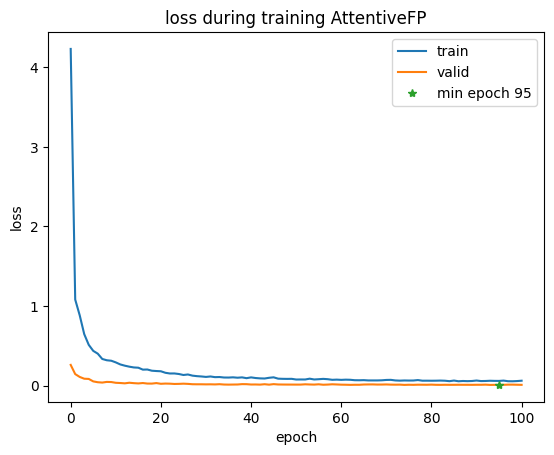

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.369  &0.196  &0.442  &0.580

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.915  &1.842  &1.357  &0.844

Epoch:101 [Train] Loss: 0.055 | [Valid] Loss: 0.008	EarlyStopping counter: 6 out of 30
Epoch:102 [Train] Loss: 0.053 | [Valid] Loss: 0.013	EarlyStopping counter: 7 out of 30
Epoch:103 [Train] Loss: 0.053 | [Valid] Loss: 0.010	EarlyStopping counter: 8 out of 30
Epoch:104 [Train] Loss: 0.059 | [Valid] Loss: 0.011	EarlyStopping counter: 9 out of 30
Epoch:105 [Train] Loss: 0.056 | [Valid] Loss: 0.010	EarlyStopping counter: 10 out of 30
Epoch:106 [Train] Loss: 0.053 | [Valid] Loss: 0.013	EarlyStopping counter: 11 out of 30
Epoch:107 [Train] Loss: 0.054 | [Valid] Loss: 0.009	EarlyStopping counter: 12 out of 30
Epoch:108 [Train] Loss: 0.057 | [Valid] Loss: 0.008	EarlyStopping counter: 13 out of 30
Epoch:109 [Train] Loss: 0.055 | [Valid] Loss: 0.009	EarlyStopping counter:

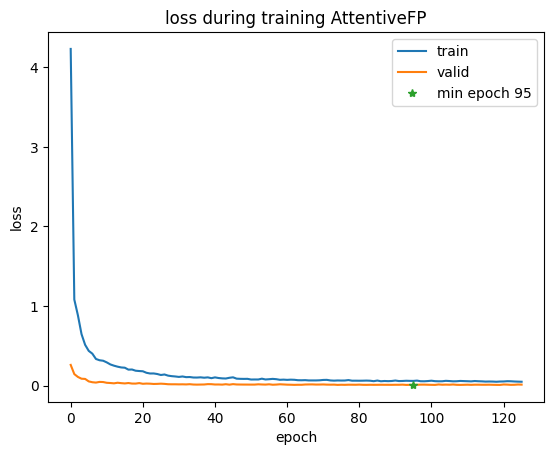

load pretrained model from  uw/AttentiveFP_MT_0.pt
[Test] Loss: 0.006
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.354  &0.201  &0.448  &0.568


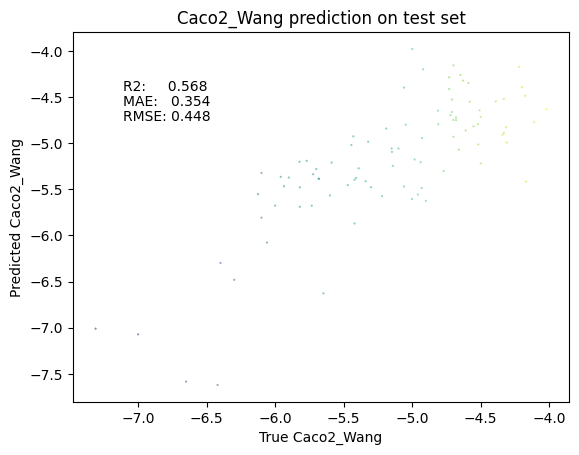


*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.913  &1.799  &1.341  &0.847


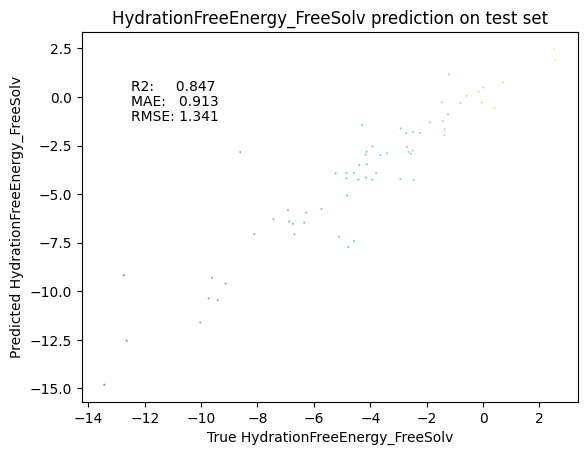



--> Train status saved at uw/AttentiveFP_MT_0.yml
Finished training

******************** Caco2_Wang ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.354 +/- 0.000 | 0.201 +/- 0.000 | 0.448 +/- 0.000 | 0.568 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.913 +/- 0.000 | 1.799 +/- 0.000 | 1.341 +/- 0.000 | 0.847 +/- 0.000 | 


Run # 1 for AttentiveFP MT	 | save dir:  uw/AttentiveFP_MT_1
Model type:  AttentiveFP | Model parameters:  3823808
Start training AttentiveFP...
Epoch:0 [Train] Loss: 3.875 | [Valid] Loss: 0.285	SAVE MODEL: loss: inf -> 0.285 | runtime: 0.348 ms
Epoch:1 [Train] Loss: 0.987 | [Valid] Loss: 0.149	SAVE MODEL: loss: 0.285 -> 0.149 | runtime: 0.337 ms
Epoch:2 [Train] Loss: 0.748 | [Valid] Loss: 0.086	SAVE MODEL: loss: 0.149 -> 0.086 | runtime: 0.337 ms
Epoch:3 [Train] Loss: 0.559 | [Valid] Loss: 0.063	SAVE MODEL: loss: 0.086 -> 0.063 | runtime: 0.339 ms
Epoch:4 [Train] Loss: 0.4

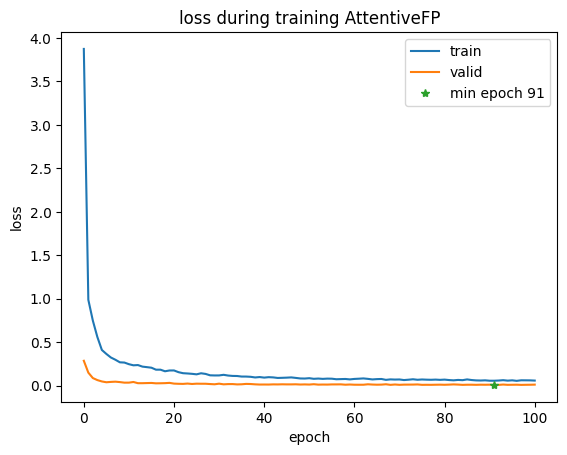

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.377  &0.208  &0.456  &0.554

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.993  &1.964  &1.401  &0.833

Epoch:101 [Train] Loss: 0.058 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 0.341 ms
Epoch:102 [Train] Loss: 0.058 | [Valid] Loss: 0.010	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.059 | [Valid] Loss: 0.010	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.056 | [Valid] Loss: 0.008	EarlyStopping counter: 3 out of 30
Epoch:105 [Train] Loss: 0.061 | [Valid] Loss: 0.009	EarlyStopping counter: 4 out of 30
Epoch:106 [Train] Loss: 0.058 | [Valid] Loss: 0.011	EarlyStopping counter: 5 out of 30
Epoch:107 [Train] Loss: 0.053 | [Valid] Loss: 0.011	EarlyStopping counter: 6 out of 30
Epoch:108 [Train] Loss: 0.051 | [Valid] Loss: 0.010	EarlyStopping counter: 7 out of 30
Epoch:109 [Train] Loss: 0.054 | [Valid] Loss: 0.007	SAVE MOD

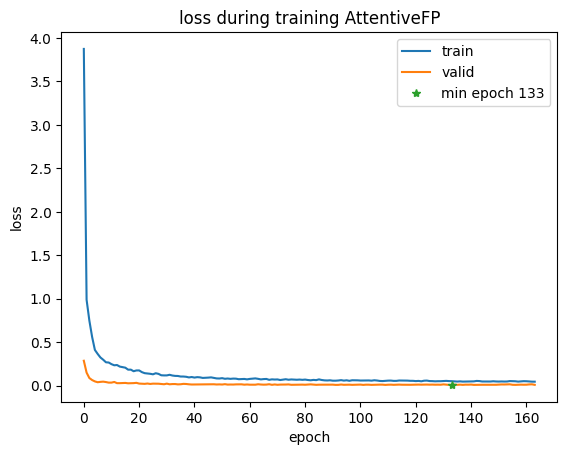

load pretrained model from  uw/AttentiveFP_MT_1.pt
[Test] Loss: 0.006
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.355  &0.186  &0.431  &0.601


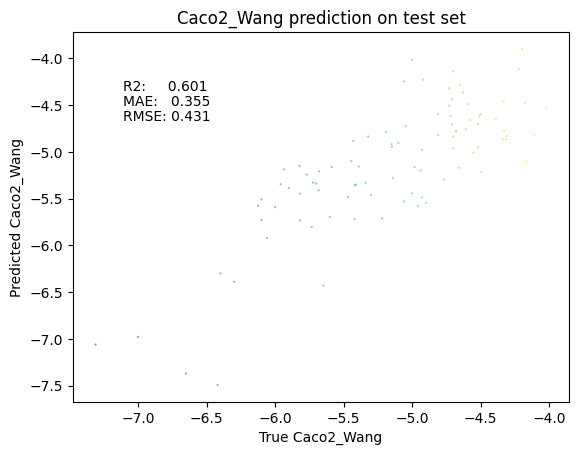


*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.986  &2.081  &1.442  &0.824


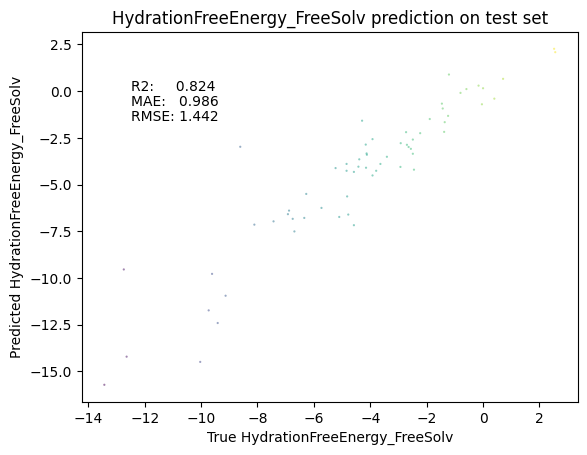



--> Train status saved at uw/AttentiveFP_MT_1.yml
Finished training

******************** Caco2_Wang ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.355 +/- 0.000 | 0.186 +/- 0.000 | 0.431 +/- 0.000 | 0.601 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.986 +/- 0.000 | 2.081 +/- 0.000 | 1.442 +/- 0.000 | 0.824 +/- 0.000 | 


Run # 2 for AttentiveFP MT	 | save dir:  uw/AttentiveFP_MT_2
Model type:  AttentiveFP | Model parameters:  3823808
Start training AttentiveFP...
Epoch:0 [Train] Loss: 4.746 | [Valid] Loss: 0.231	SAVE MODEL: loss: inf -> 0.231 | runtime: 0.342 ms
Epoch:1 [Train] Loss: 1.169 | [Valid] Loss: 0.171	SAVE MODEL: loss: 0.231 -> 0.171 | runtime: 0.350 ms
Epoch:2 [Train] Loss: 0.842 | [Valid] Loss: 0.123	SAVE MODEL: loss: 0.171 -> 0.123 | runtime: 0.349 ms
Epoch:3 [Train] Loss: 0.686 | [Valid] Loss: 0.098	SAVE MODEL: loss: 0.123 -> 0.098 | runtime: 0.331 ms
Epoch:4 [Train] Loss: 0.5

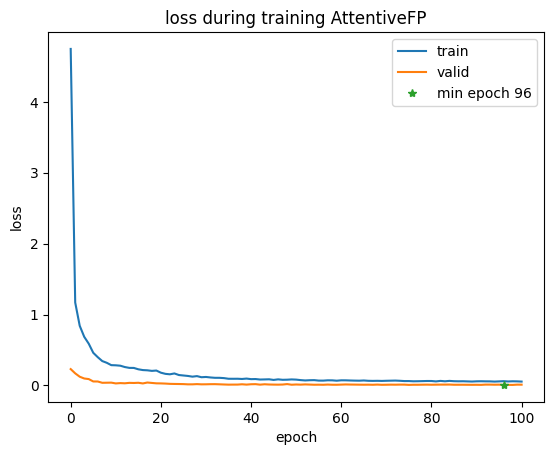

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.354  &0.192  &0.438  &0.587

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.912  &1.920  &1.386  &0.837

Epoch:101 [Train] Loss: 0.053 | [Valid] Loss: 0.011	EarlyStopping counter: 5 out of 30
Epoch:102 [Train] Loss: 0.054 | [Valid] Loss: 0.010	EarlyStopping counter: 6 out of 30
Epoch:103 [Train] Loss: 0.051 | [Valid] Loss: 0.010	EarlyStopping counter: 7 out of 30
Epoch:104 [Train] Loss: 0.051 | [Valid] Loss: 0.012	EarlyStopping counter: 8 out of 30
Epoch:105 [Train] Loss: 0.052 | [Valid] Loss: 0.010	EarlyStopping counter: 9 out of 30
Epoch:106 [Train] Loss: 0.049 | [Valid] Loss: 0.009	EarlyStopping counter: 10 out of 30
Epoch:107 [Train] Loss: 0.053 | [Valid] Loss: 0.009	EarlyStopping counter: 11 out of 30
Epoch:108 [Train] Loss: 0.048 | [Valid] Loss: 0.010	EarlyStopping counter: 12 out of 30
Epoch:109 [Train] Loss: 0.051 | [Valid] Loss: 0.012	EarlyStopping counter: 

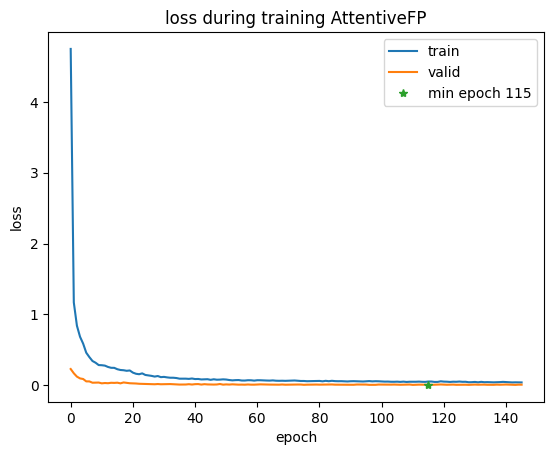

load pretrained model from  uw/AttentiveFP_MT_2.pt
[Test] Loss: 0.006
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.342  &0.179  &0.423  &0.616


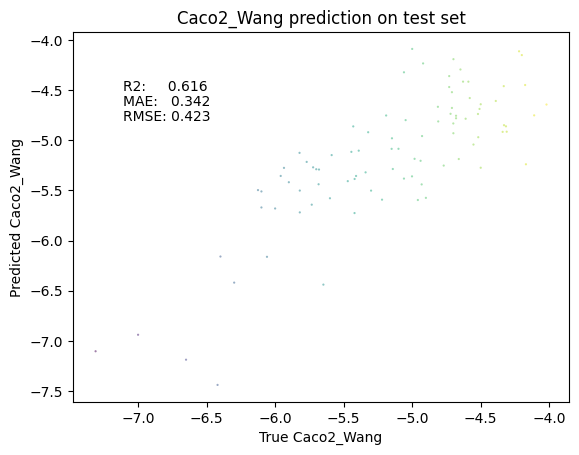


*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.890  &1.788  &1.337  &0.848


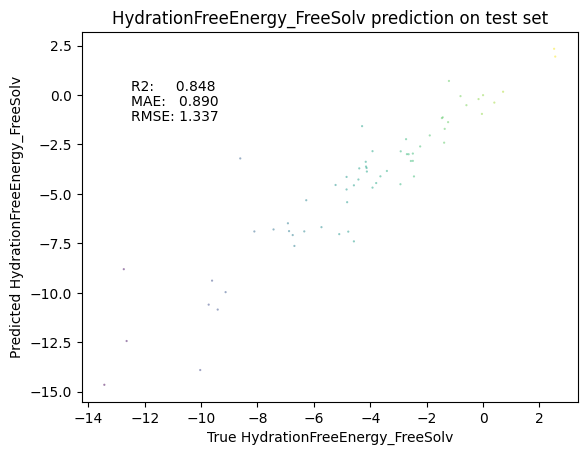



--> Train status saved at uw/AttentiveFP_MT_2.yml
Finished training

******************** Caco2_Wang ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.342 +/- 0.000 | 0.179 +/- 0.000 | 0.423 +/- 0.000 | 0.616 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.890 +/- 0.000 | 1.788 +/- 0.000 | 1.337 +/- 0.000 | 0.848 +/- 0.000 | 


Run # 3 for AttentiveFP MT	 | save dir:  uw/AttentiveFP_MT_3
Model type:  AttentiveFP | Model parameters:  3823808
Start training AttentiveFP...
Epoch:0 [Train] Loss: 4.768 | [Valid] Loss: 0.212	SAVE MODEL: loss: inf -> 0.212 | runtime: 0.340 ms
Epoch:1 [Train] Loss: 1.225 | [Valid] Loss: 0.215	EarlyStopping counter: 1 out of 30
Epoch:2 [Train] Loss: 0.832 | [Valid] Loss: 0.115	SAVE MODEL: loss: 0.212 -> 0.115 | runtime: 0.322 ms
Epoch:3 [Train] Loss: 0.704 | [Valid] Loss: 0.093	SAVE MODEL: loss: 0.115 -> 0.093 | runtime: 0.347 ms
Epoch:4 [Train] Loss: 0.593 | [Valid] Loss:

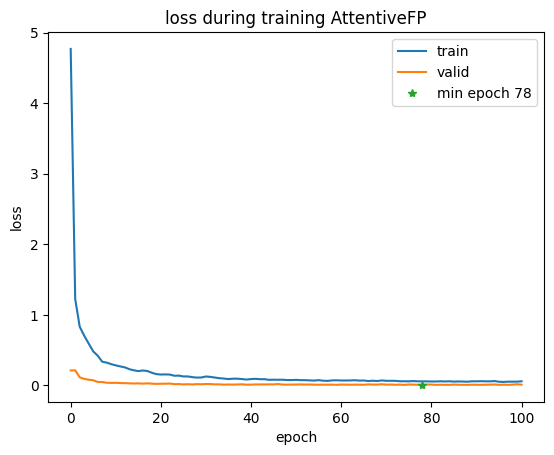

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.381  &0.233  &0.483  &0.499

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.241  &2.791  &1.671  &0.763

Epoch:101 [Train] Loss: 0.055 | [Valid] Loss: 0.012	EarlyStopping counter: 23 out of 30
Epoch:102 [Train] Loss: 0.053 | [Valid] Loss: 0.008	EarlyStopping counter: 24 out of 30
Epoch:103 [Train] Loss: 0.051 | [Valid] Loss: 0.013	EarlyStopping counter: 25 out of 30
Epoch:104 [Train] Loss: 0.058 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.008 -> 0.008 | runtime: 0.331 ms
Epoch:105 [Train] Loss: 0.050 | [Valid] Loss: 0.009	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.048 | [Valid] Loss: 0.010	EarlyStopping counter: 2 out of 30
Epoch:107 [Train] Loss: 0.050 | [Valid] Loss: 0.009	EarlyStopping counter: 3 out of 30
Epoch:108 [Train] Loss: 0.051 | [Valid] Loss: 0.011	EarlyStopping counter: 4 out of 30
Epoch:109 [Train] Loss: 0.052 | [Valid] Loss: 0.008	Early

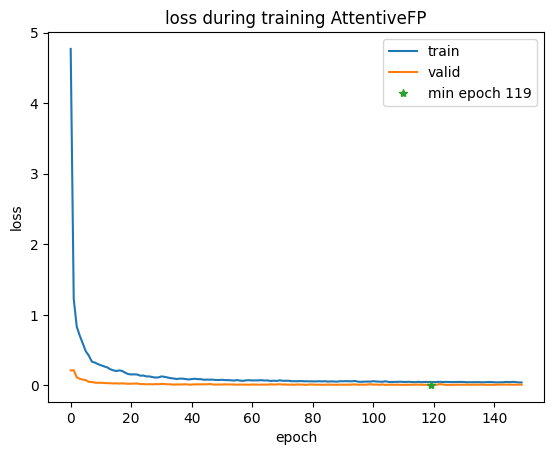

load pretrained model from  uw/AttentiveFP_MT_3.pt
[Test] Loss: 0.006
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.346  &0.184  &0.429  &0.606


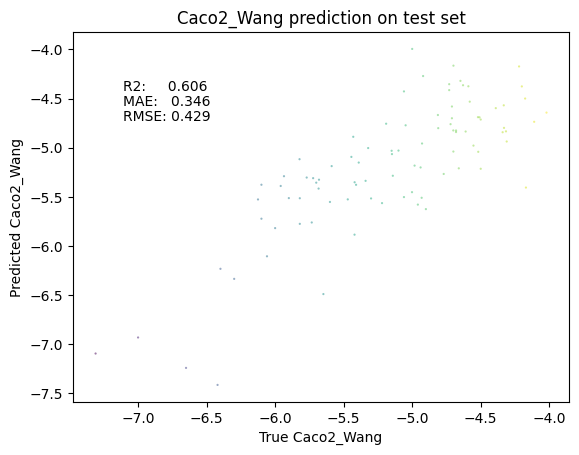


*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.987  &2.165  &1.472  &0.816


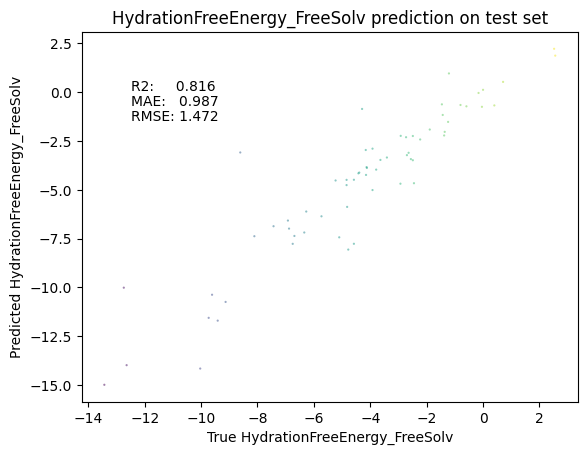



--> Train status saved at uw/AttentiveFP_MT_3.yml
Finished training

******************** Caco2_Wang ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.346 +/- 0.000 | 0.184 +/- 0.000 | 0.429 +/- 0.000 | 0.606 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.987 +/- 0.000 | 2.165 +/- 0.000 | 1.472 +/- 0.000 | 0.816 +/- 0.000 | 


Run # 4 for AttentiveFP MT	 | save dir:  uw/AttentiveFP_MT_4
Model type:  AttentiveFP | Model parameters:  3823808
Start training AttentiveFP...
Epoch:0 [Train] Loss: 5.161 | [Valid] Loss: 0.229	SAVE MODEL: loss: inf -> 0.229 | runtime: 0.349 ms
Epoch:1 [Train] Loss: 1.179 | [Valid] Loss: 0.186	SAVE MODEL: loss: 0.229 -> 0.186 | runtime: 0.345 ms
Epoch:2 [Train] Loss: 0.810 | [Valid] Loss: 0.142	SAVE MODEL: loss: 0.186 -> 0.142 | runtime: 0.328 ms
Epoch:3 [Train] Loss: 0.696 | [Valid] Loss: 0.094	SAVE MODEL: loss: 0.142 -> 0.094 | runtime: 0.328 ms
Epoch:4 [Train] Loss: 0.5

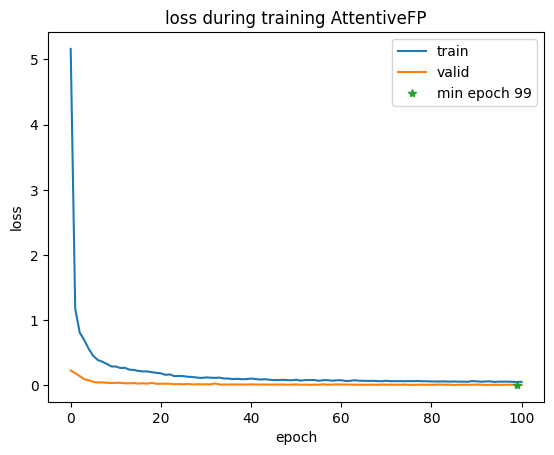

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.347  &0.181  &0.426  &0.611

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.927  &1.817  &1.348  &0.846

Epoch:101 [Train] Loss: 0.053 | [Valid] Loss: 0.011	EarlyStopping counter: 2 out of 30
Epoch:102 [Train] Loss: 0.057 | [Valid] Loss: 0.008	EarlyStopping counter: 3 out of 30
Epoch:103 [Train] Loss: 0.052 | [Valid] Loss: 0.010	EarlyStopping counter: 4 out of 30
Epoch:104 [Train] Loss: 0.056 | [Valid] Loss: 0.008	EarlyStopping counter: 5 out of 30
Epoch:105 [Train] Loss: 0.049 | [Valid] Loss: 0.007	EarlyStopping counter: 6 out of 30
Epoch:106 [Train] Loss: 0.052 | [Valid] Loss: 0.009	EarlyStopping counter: 7 out of 30
Epoch:107 [Train] Loss: 0.052 | [Valid] Loss: 0.008	EarlyStopping counter: 8 out of 30
Epoch:108 [Train] Loss: 0.051 | [Valid] Loss: 0.007	EarlyStopping counter: 9 out of 30
Epoch:109 [Train] Loss: 0.051 | [Valid] Loss: 0.009	EarlyStopping counter: 10 

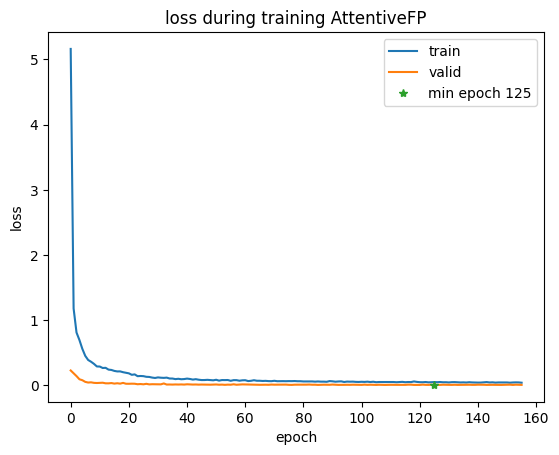

load pretrained model from  uw/AttentiveFP_MT_4.pt
[Test] Loss: 0.005
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.329  &0.165  &0.406  &0.645


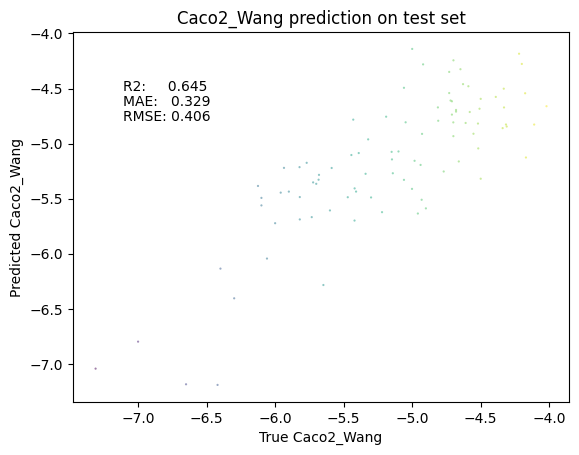


*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.857  &1.676  &1.295  &0.858


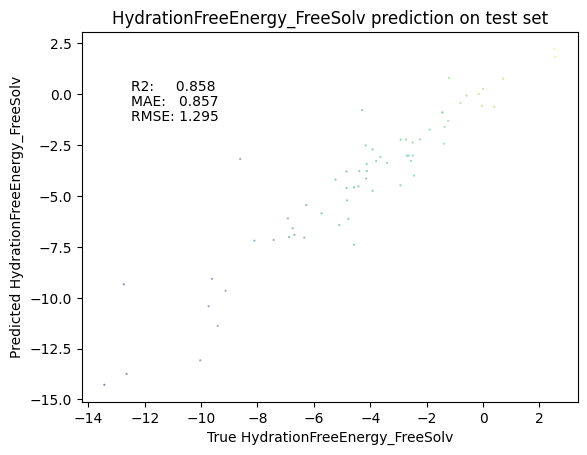



--> Train status saved at uw/AttentiveFP_MT_4.yml
Finished training

******************** Caco2_Wang ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.329 +/- 0.000 | 0.165 +/- 0.000 | 0.406 +/- 0.000 | 0.645 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.857 +/- 0.000 | 1.676 +/- 0.000 | 1.295 +/- 0.000 | 0.858 +/- 0.000 | 

repeated num # 5 idx 4 has the lowest loss from [0.005894084228202701, 0.006185730337165296, 0.0055033022072166204, 0.00618446699809283, 0.005070260725915432]
******************** Caco2_Wang ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.345 +/- 0.009 | 0.427 +/- 0.014 | 0.607 +/- 0.025 | 
 idx 4: | 0.329 +/- 0.000 | 0.406 +/- 0.000 | 0.645 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.927 +/- 0.052 | 1.377 +/- 0.068 | 0.839 +/- 0.016 | 
 idx 4: | 0.857 +/- 0.000 | 1.295 +/- 0.000 | 0.858 +/- 0.000 

In [30]:
folder_name = 'uw'
make_path(folder_name, False)
perfs = [] # a list to store the performance outputted from the model
repeat_time = 5
retrain = True
print('retrain model and delete past models: ', retrain)

for i in range(repeat_time): # run the same model for repeat_time times
    print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
    save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
    print(' | save dir: ', save_dir)
    config['model_path']  = save_dir + '.pt'
    config['config_path'] = save_dir + '.yml'
    config['uncertainty_weight'] = True
    config['verbose_freq'] = 100
    config['patience'] = 30

    nofile = False
    if retrain == False:
        try: # try open yml file, if file exists, and no need train
            with open(config['config_path'], 'r') as f: data = yaml.safe_load(f)
            if data != None: p = yml_report(data); print('--> pre data loaded')
            nofile = False
        except:  nofile = True # model was not trained yet, train the model
    if nofile or retrain:

        models = PRED(**config); p = models.train(trn_l, val_l, tst_l)





    eval_perf_list(p, name, {}); perfs.append(p)
eval_perf_list(perfs, name)

In [31]:
# p = yml_report(config['config_path'], ver=False)
# # eval_perf_list(p, name, metrics_dict={})
# eval_perf_list(p, name)
eval_perf_list(perfs, name)

repeated num # 5 idx 4 has the lowest loss from [0.005894084228202701, 0.006185730337165296, 0.0055033022072166204, 0.00618446699809283, 0.005070260725915432]
******************** Caco2_Wang ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.345 +/- 0.009 | 0.427 +/- 0.014 | 0.607 +/- 0.025 | 
 idx 4: | 0.329 +/- 0.000 | 0.406 +/- 0.000 | 0.645 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.927 +/- 0.052 | 1.377 +/- 0.068 | 0.839 +/- 0.016 | 
 idx 4: | 0.857 +/- 0.000 | 1.295 +/- 0.000 | 0.858 +/- 0.000 | 



In [32]:
eval_multi_run(model_type, name, ['uw', 'uw_no'], repeat_time=5, run_type='MT')

checking uw
repeated num # 5 idx 4 has the lowest loss from [0.005894084228202701, 0.006185730337165296, 0.0055033022072166204, 0.00618446699809283, 0.005070260725915432]
******************** Caco2_Wang ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.345 +/- 0.009 | 0.427 +/- 0.014 | 0.607 +/- 0.025 | 
 idx 4: | 0.329 +/- 0.000 | 0.406 +/- 0.000 | 0.645 +/- 0.000 | 

******************** HydrationFreeEnergy_FreeSolv ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.927 +/- 0.052 | 1.377 +/- 0.068 | 0.839 +/- 0.016 | 
 idx 4: | 0.857 +/- 0.000 | 1.295 +/- 0.000 | 0.858 +/- 0.000 | 

checking uw_no
repeated num # 5 idx 3 has the lowest loss from [0.014976000878959894, 0.015220217406749725, 0.014839220559224486, 0.014693690580315888, 0.0158398668281734]
******************** Caco2_Wang ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.353 +/- 0.004 | 0.429 +/- 0.007 | 0.605 +/- 0.013 | 
 idx 3: | 0.350 +/- 0.000 | 0.423 +/- 0.000 | 0.617 +/- 0.000 | 

******************** Hydrat